### UNet
----------------
![](https://search.pstatic.net/common/?src=http%3A%2F%2Fblogfiles.naver.net%2FMjAyMDA0MDNfMjgx%2FMDAxNTg1ODgyMDY2MTUw.aV4rP5KrYnFL24FCg-xpuGdc319YOMWY5H5GqMRHh50g.u_t5lKPe4DDm4VU7wLOcq9sWCMAGcPKj4OJxPmKUFrIg.PNG.kswoo3030%2Fec0ac2e2d2df8f213b916453375ccee95a254ac3.png)

In [42]:
# !jar xvf pavement_crack.zip

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision.transforms as transforms

import os, zipfile
import tqdm
import random
import shutil
import numpy as np
from PIL import Image
from pathlib import Path
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt

In [2]:
# 재현성을 위한 랜덤시드 고정
random_seed = 2024
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

### 균열 데이터 클래스 정의


In [3]:
# 클래스 정의
class CrackDatasets(Dataset):
    def __init__(self, img_dir, mask_dir, img_transform, mask_transform):
        self.img_dir = img_dir
        self.img_transform = img_transform
        self.img_files = []
        self.mask_dir = mask_dir
        self.mask_transform = mask_transform
        self.mask_files = []
        self.seed = np.random.randint(2024)

        for img_name in os.listdir(self.img_dir):
            if img_name.split('.')[-1] in ('png', 'jpg'):
                self.img_files.append(os.path.join(self.img_dir, img_name))
                self.mask_files.append(os.path.join(self.mask_dir, img_name))

    def __getitem__(self, i):
        img = Image.open(self.img_files[i])
        if self.img_transform is not None:
            random.seed(self.seed)
            img = self.img_transform(img)

        mask = Image.open(self.mask_files[i]).convert('L')
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)

        return img, mask

    def __len__(self):
        return len(self.img_files)

### Dice Score와 IoU 메트릭 함수 정의

In [4]:
def dice_coeff(input, target, reduce_batch_first: bool = False, epsilon: float=1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()

def iou(y_true, y_pred, epsilon: float = 1e-6):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + epsilon) / (union + epsilon)

### UNet 모델 클래스 정의

In [5]:
class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.middle = self.conv_block(in_channels=512, out_channels=1024)

        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)

        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)

        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)

        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)

        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                             nn.ReLU(),
                             nn.BatchNorm2d(num_features=out_channels),
                             nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                             nn.ReLU(),
                             nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):
        contracting_11_out = self.contracting_11(X) #[-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) #[-1, 64, 128, 128]

        contracting_21_out = self.contracting_21(contracting_12_out) #[-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) #[-1, 128, 64, 64]

        contracting_31_out = self.contracting_31(contracting_22_out) #[-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) #[-1, 256, 32, 32]

        contracting_41_out = self.contracting_41(contracting_32_out) #[-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) #[-1, 512, 16, 16]

        middle_out = self.middle(contracting_42_out) #[-1, 512, 32, 32]

        expansive_11_out = self.expansive_11(middle_out) #[-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1))
        # [-1, 1024, 32, 32] -> # [-1, 512, 32, 32]
        
        expansive_21_out = self.expansive_21(expansive_12_out) #[-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1))
        # [-1, 512, 64, 64] -> # [-1, 256, 64, 64]
        
        expansive_31_out = self.expansive_31(expansive_22_out) #[-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1))
        # [-1, 256, 128, 128] -> # [-1, 128, 128, 128]
        
        expansive_41_out = self.expansive_41(expansive_32_out)
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out,contracting_11_out), dim=1))
        #[-1, 128, 256, 256] -> # [1, 64, 256,256]
        
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out


#### 유틸 함수 정의

In [6]:
class AverageMeter(object):
    #Computes and stores the average and current value
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def adjust_learning_rate(optimizer, epoch, lr):
    #Sets the learning rate to the initial LR decayed by 10 every 30 epochs
    lr = lr * (0.1 **(epoch//30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def find_latest_model_path(dir):
    model_paths = []
    epochs = []
    for path in Path(dir).glob('*.pth'):
        if 'epoch' not in path.stem:
            continue
        model_paths.append(path)
        parts = path.stem.split('_')
        epoch = int(parts[-1])
        epochs.append(epoch)

    if len(epochs) > 0:
        epochs = np.array(epochs)
        max_idx = np.argmax(epochs)
        return model_paths[max_idx]
    else:
        return None

def save_check_point(state, is_best, file_name='checkpoint.pth'):
    torch.save(state, file_name)
    if is_best:
        shutil.copy(file_name, 'model_best.pth')

def calc_crack_pixel_weight(mask_dir):
    avg_w = 0.0
    n_files = 0
    for path in Path(mask_dir).glob('*.*'):
        n_files += 1
        m = ndimage.imread(path)
        ncrack = np.sum((m>0)[:])
        w = float(ncrack) / (m.shape[0]*m.shape[1])
        avg_w = avg_w + (1-w)

    return avg_w / (1.0 - avg_w)

### train & validation function

In [7]:
def train(train_loader, model, criterion, optimizer, valid_loader, model_dir, n_epoch, batch_size, lr, device):

    latest_model_path = find_latest_model_path(model_dir)
    best_model_path = os.path.join(*[model_dir, 'model_best.pth'])

    if latest_model_path is not None:
        state = torch.load(latest_model_path)
        epoch = state['epoch']
        model.load_state_dict(state['model'])
        epoch = epoch

        # if latest model path does exist, best_model_path should exists as well
        assert Path(best_model_path).exists() == True, f'best model path {best_model_path} doest not exist'
        # load the min loss so far
        best_state = torch.load(latest_model_path)
        min_val_los = best_state['valid_loss']

        print(f'Restored model at epoch {epoch}. Min Validation loss so far is: {min_val_los}')
        epoch += 1
        print(f'Started training model from epoch {epoch}')
    else:
        print('Started training model from epoch 0')
        epoch = 0
        min_val_los = 9999

    valid_losses = []
    for epoch in range(epoch, n_epoch):
        adjust_learning_rate(optimizer, epoch, lr)

        tq = tqdm.tqdm(total=(len(train_loader) * batch_size))
        tq.set_description(f'Epoch {epoch}')

        losses = AverageMeter()
        t_iou = 0
        t_dice = 0

        model.train()
        for i, (input, target) in enumerate(train_loader):
            input_var = Variable(input).to(device)
            target_var = Variable(target).to(device)

            masks_pred = model(input_var)
            pred = F.sigmoid(masks_pred)
            target_mask = target_var

            pred[pred>0.5] = 1
            pred[pred<=0.5] = 0
            target_mask[target_mask>0.5] = 1
            target_mask[target_mask<=0.5] = 0

            masks_prob_flat = masks_pred.view(-1)
            true_masks_flat = target_var.view(-1)

            loss = criterion(masks_prob_flat, true_masks_flat)
            losses.update(loss)
            tq.set_postfix(loss='{:.5f}'.format(losses.avg))
            tq.update(batch_size)

            t_dice += dice_coeff(pred, target_mask)
            t_iou += iou(pred, target_mask)

            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'train miou : {t_iou/len(train_loader):.5f} train dice score : {t_dice/len(train_loader):.5f}')
        valid_metrics = valid(model, valid_loader, criterion)
        valid_loss = valid_metrics['valid_loss']
        valid_dice = valid_metrics['v_dice']
        valid_iou = valid_metrics['v_iou']
        valid_losses.append(valid_loss)
        print(f'valid_loss = {valid_loss:.5f}')
        print(f'valid miou : {valid_iou/len(valid_loader):.5f} valid dice score : {valid_dice/len(valid_loader):.5f}')
        tq.close()

        # save the model of the current epoch
        epoch_model_path = os.path.join(*[model_dir, f'model_epoch_{epoch}.pth'])
        torch.save({
            'model': model.state_dict(),
            'epoch': epoch,
            'valid_loss': valid_loss,
            'train_loss': losses.avg
        }, epoch_model_path)

        if valid_loss < min_val_los:
            min_val_los = valid_loss

            torch.save({
                'model' : model.state_dict(),
                'epoch' : epoch,
                'valid_loss' : valid_loss,
                'train_loss' : losses.avg
            }, best_model_path)

In [8]:
def valid(model, val_loader, criterion):
    losses = AverageMeter()
    v_iou = 0
    v_dice = 0
    model.eval()
    with torch.no_grad():

        for i, (input, target) in enumerate(val_loader):
            input_var = Variable(input).to(device)
            target_var = Variable(target).to(device)

            output = model(input_var)
            loss = criterion(output, target_var)

            losses.update(loss.item(), input_var.size(0))

            pred = F.sigmoid(output)
            target_mask = target_var
            pred[pred>0.5] = 1
            pred[pred<=0.5] = 0
            target_mask[target_mask>0.5] = 1
            target_mask[target_mask<=0.5] = 0

            v_dice += dice_coeff(pred, target_mask)
            v_iou = iou(pred, target_mask)

    return {'valid_loss': losses.avg, 'v_dice': v_dice, 'v_iou': v_iou}

### parameter

In [9]:
# model folder
model_dir = '/root/2024winter/DL_tutorial/posts/model_weights'
os.makedirs(model_dir, exist_ok=True)

# data folder
data_dir = '/root/2024winter/DL_tutorial/posts/crack_segmentation_dataset/train'
DIR_IMG = os.path.join(data_dir, 'images')
DIR_MASK = os.path.join(data_dir, 'masks')

# Device 할당
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr = 0.001
momentum = 0.9
weight_decay = 1e-4
batch_size = 8
num_workers = 8
n_epoch = 10

In [10]:
# 모델 할당
model = UNet(num_classes=1)

# Optimizer 정의
optimizer = torch.optim.SGD(model.parameters(), lr,
                           momentum=momentum,
                           weight_decay=weight_decay)

# 손실 함수 정의
criterion = nn.BCEWithLogitsLoss().to(device)

channel_means = [0.485, 0.456, 0.406]
channel_stds  = [0.229, 0.224, 0.224]

train_tfms = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(256),
                                transforms.Normalize(channel_means, channel_stds)])

val_tfms = transforms.Compose([transforms.ToTensor(),
                              transforms.Resize(256),
                              transforms.Normalize(channel_means, channel_stds)])

mask_tfms = transforms.Compose([transforms.ToTensor(),
                               transforms.Resize(256)])

dataset = CrackDatasets(img_dir=DIR_IMG,
                       img_transform=train_tfms,
                       mask_dir=DIR_MASK,
                       mask_transform=mask_tfms)

train_size = int(0.85*len(dataset))
valid_size = len(dataset) - train_size

# train / val 분할
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# 데이터로더
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=num_workers)

model.to(device)

#train
train(train_loader, model, criterion, optimizer,
      valid_loader, model_dir, n_epoch, batch_size, lr, device)

Started training model from epoch 0


Epoch 0:   0%|                                                                                 | 0/8168 [00:00<?, ?it/s]/root/anaconda3/envs/dl/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|███████████████████████████████████████████████████████▉| 8160/8168 [01:18<00:00, 88.84it/s, loss=0.20300]

train miou : 0.16975 train dice score : 0.23192


Epoch 0: 100%|████████████████████████████████████████████████████████| 8168/8168 [01:24<00:00, 96.69it/s, loss=0.20300]

valid_loss = 0.10602
valid miou : 0.00013 valid dice score : 0.21843



Epoch 1: 100%|███████████████████████████████████████████████████████| 8168/8168 [01:11<00:00, 120.05it/s, loss=0.09282]

train miou : 0.27445 train dice score : 0.34929


Epoch 1: 100%|███████████████████████████████████████████████████████| 8168/8168 [01:17<00:00, 106.00it/s, loss=0.09282]

valid_loss = 0.09925
valid miou : 0.00038 valid dice score : 0.26572



Epoch 2: 100%|███████████████████████████████████████████████████████| 8168/8168 [01:12<00:00, 120.32it/s, loss=0.08378]

train miou : 0.32347 train dice score : 0.41108


Epoch 2: 100%|███████████████████████████████████████████████████████| 8168/8168 [01:17<00:00, 105.32it/s, loss=0.08378]

valid_loss = 0.08654
valid miou : 0.00108 valid dice score : 0.37338



Epoch 3: 100%|██████████████████████████████████████████████████████▉| 8160/8168 [01:11<00:00, 118.50it/s, loss=0.07736]

train miou : 0.36215 train dice score : 0.44759


Epoch 3: 100%|███████████████████████████████████████████████████████| 8168/8168 [01:15<00:00, 107.60it/s, loss=0.07736]

valid_loss = 0.08282
valid miou : 0.00079 valid dice score : 0.47123



Epoch 4: 100%|███████████████████████████████████████████████████████| 8168/8168 [01:13<00:00, 107.44it/s, loss=0.07263]

train miou : 0.38905 train dice score : 0.48338


Epoch 4: 100%|███████████████████████████████████████████████████████| 8168/8168 [01:20<00:00, 101.28it/s, loss=0.07263]

valid_loss = 0.07262
valid miou : 0.00085 valid dice score : 0.49158



Epoch 5: 100%|██████████████████████████████████████████████████████▉| 8160/8168 [01:17<00:00, 114.78it/s, loss=0.06974]

train miou : 0.40778 train dice score : 0.50428


Epoch 5: 100%|████████████████████████████████████████████████████████| 8168/8168 [01:23<00:00, 97.74it/s, loss=0.06974]

valid_loss = 0.07109
valid miou : 0.00097 valid dice score : 0.52032



Epoch 6: 100%|███████████████████████████████████████████████████████| 8168/8168 [01:15<00:00, 111.50it/s, loss=0.06713]

train miou : 0.42189 train dice score : 0.52392


Epoch 6: 100%|███████████████████████████████████████████████████████| 8168/8168 [01:21<00:00, 100.49it/s, loss=0.06713]

valid_loss = 0.06942
valid miou : 0.00078 valid dice score : 0.54654



Epoch 7: 100%|██████████████████████████████████████████████████████▉| 8160/8168 [01:23<00:00, 111.52it/s, loss=0.06493]

train miou : 0.43467 train dice score : 0.53903


Epoch 7: 100%|████████████████████████████████████████████████████████| 8168/8168 [01:29<00:00, 91.64it/s, loss=0.06493]

valid_loss = 0.06694
valid miou : 0.00077 valid dice score : 0.52760



Epoch 8: 100%|██████████████████████████████████████████████████████▉| 8160/8168 [01:14<00:00, 111.54it/s, loss=0.06300]

train miou : 0.44633 train dice score : 0.55094


Epoch 8: 100%|███████████████████████████████████████████████████████| 8168/8168 [01:20<00:00, 101.57it/s, loss=0.06300]

valid_loss = 0.06965
valid miou : 0.00069 valid dice score : 0.55299



Epoch 9: 100%|███████████████████████████████████████████████████████| 8168/8168 [01:14<00:00, 119.27it/s, loss=0.06161]

train miou : 0.45546 train dice score : 0.55663


Epoch 9: 100%|███████████████████████████████████████████████████████| 8168/8168 [01:20<00:00, 101.92it/s, loss=0.06161]

valid_loss = 0.06245
valid miou : 0.00043 valid dice score : 0.55632


In [11]:
for images, masks in train_loader:
    print(images.shape, masks.shape)
    break

torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])


In [9]:
import gc
gc.collect()
torch.cuda.empty_cache()

[PosixPath('/root/2024winter/DL_tutorial/posts/model_weights/model_best.pth'), PosixPath('/root/2024winter/DL_tutorial/posts/model_weights/model_epoch_0.pth'), PosixPath('/root/2024winter/DL_tutorial/posts/model_weights/model_epoch_1.pth'), PosixPath('/root/2024winter/DL_tutorial/posts/model_weights/model_epoch_2.pth'), PosixPath('/root/2024winter/DL_tutorial/posts/model_weights/model_epoch_3.pth'), PosixPath('/root/2024winter/DL_tutorial/posts/model_weights/model_epoch_4.pth'), PosixPath('/root/2024winter/DL_tutorial/posts/model_weights/model_epoch_5.pth'), PosixPath('/root/2024winter/DL_tutorial/posts/model_weights/model_epoch_6.pth'), PosixPath('/root/2024winter/DL_tutorial/posts/model_weights/model_epoch_7.pth'), PosixPath('/root/2024winter/DL_tutorial/posts/model_weights/model_epoch_8.pth'), PosixPath('/root/2024winter/DL_tutorial/posts/model_weights/model_epoch_9.pth')]


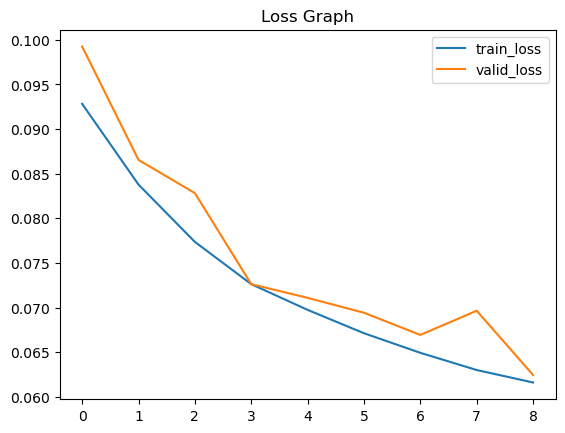

In [13]:
# 저장된 모델 웨이트로 경로 지정
model_dir = '/root/2024winter/DL_tutorial/posts/model_weights'
title="Loss Graph"

weights_paths = [path for path in Path(model_dir).glob('*.pth')]
weights_paths = sorted(weights_paths)
print(weights_paths)
epochs = []
tr_losses = []
vl_losses = []

for w_path in weights_paths:
    if 'epoch' not in w_path.stem:
        continue
    # load the min loss so far
    parts = w_path.stem.split('_')
    epoch = int(parts[-1])
    epochs.append(epoch)
    state = torch.load(w_path)
    val_los = state['valid_loss']
    train_loss = float(state['train_loss'])
    tr_losses.append(train_loss)
    vl_losses.append(val_los)

sorted_idx = np.argsort(epochs)
tr_losses = [tr_losses[idx] for idx in sorted_idx]
vl_losses = [vl_losses[idx] for idx in sorted_idx]
plt.plot(tr_losses[1:], label='train_loss')
plt.plot(vl_losses[1:], label='valid_loss')
plt.title(title)
plt.legend()
plt.show()

In [14]:
import cv2
def evaluate(test_loader, model, output_path):
    e_iou = 0
    e_dice = 0
    model.eval()
    with torch.no_grad():
        for i, (input, target) in enumerate(test_loader):
            input_var = Variable(input).to(device)
            target_var = Variable(target).to(device)

            output = model(input_var)
            pred = F.sigmoid(output)
            target_mask = target_var

            pred[pred>0.5]=1
            pred[pred<=0.5]=0
            target_mask[target_mask>0.5]=1
            target_mask[target_mask<=0.5]=0
            
            cv2.imwrite(f'{output_path}/predicts/{i}.png', tensor2image(pred))
            cv2.imwrite(f'{output_path}/masks/{i}.png', tensor2image(target_mask))

            e_dice += dice_coeff(pred, target_mask)
            e_iou += iou(pred, target_mask)

    print(f'test miou : {e_iou/len(test_loader):.5f} test dice score : {e_dice/len(test_loader):.5f}')

In [15]:
def denormalize(image):
    #IMAGENET_MEAN, IMAGENET_STD = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
    #image = np.clip(255.0 * (image * IMAGENET_STD + IMAGENET_MEAN), 0, 255)
    image = image * 255.0
    return image

def tensor2image(tensor_list):
    img = tensor_list[0].detach().cpu().numpy()
    img = np.transpose(img, (1,2,0))
    img = denormalize(img)
    #img = img.astype('float32')
    #img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = img.astype(np.uint8).copy()
    return img

In [16]:
# 테스트 데이터셋
test_data_dir = '/root/2024winter/DL_tutorial/posts/crack_segmentation_dataset/test'
test_img_path = os.path.join(test_data_dir, 'images')
test_mask_path = os.path.join(test_data_dir, 'masks')

test_tfms = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(channel_means, channel_stds)])
mask_tfms = transforms.Compose([transforms.ToTensor()])

test_dataset = CrackDatasets(img_dir=test_img_path, img_transform=test_tfms,
                            mask_dir=test_mask_path, mask_transform=mask_tfms)
test_loader = DataLoader(test_dataset, 1, shuffle=False, num_workers=num_workers)

# 모델 할당
model = UNet(num_classes=1)

best_model_path = os.path.join(*[model_dir, 'model_best.pth'])
if best_model_path is not None:
    state = torch.load(best_model_path)
    epoch = state['epoch']
    model.load_state_dict(state['model'])
model.to(device)

os.makedirs('/root/2024winter/DL_tutorial/posts/results/predicts', exist_ok=True)
os.makedirs('/root/2024winter/DL_tutorial/posts/results/masks', exist_ok=True)

output_path = '/root/2024winter/DL_tutorial/posts/results'
evaluate(test_loader, model, output_path)

test miou : 0.37293 test dice score : 0.49206


#### 커스텀 데이터 다운로드
-------------

In [ ]:
!unzip /root/2024winter/DL_tutorial/posts/Semantic_Segmentation_Custom.zip

### CVAT 마스크 라벨 포맷 변경

####  .png $\to\$ .jpg

In [21]:
from PIL import Image
root_dir = '/root/2024winter/DL_tutorial/posts/Semantic_Custom_Datasets/masks'
for img in os.listdir(root_dir):
    if img.split('.')[-1] in ('png', 'jpg'):
        im = Image.open(os.path.join(root_dir, img))
        im.save(os.path.join(root_dir, img.split('.')[0]+'.jpg'))
        os.remove(os.path.join(root_dir, img))

#### 커스텀 데이터셋 성능 평가

In [22]:
test_data_dir = '/root/2024winter/DL_tutorial/posts/Semantic_Custom_Datasets'
test_img_path = os.path.join(test_data_dir, 'images')
test_mask_path = os.path.join(test_data_dir, 'masks')

test_tfms = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(channel_means, channel_stds)])
mask_tfms = transforms.Compose([transforms.ToTensor()])

test_dataset = CrackDatasets(img_dir=test_img_path, img_transform=test_tfms, mask_dir=test_mask_path, mask_transform=mask_tfms)
test_loader = DataLoader(test_dataset, 1, shuffle=False, num_workers=num_workers)

# 모델 할당
model = UNet(num_classes=1)
best_model_path = os.path.join(*[model_dir, 'model_best.pth'])

if best_model_path is not None:
    state = torch.load(best_model_path)
    epoch = state['epoch']
    model.load_state_dict(state['model'])

model.to(device)

# 결과물 저장 폴더 생성
os.makedirs('/root/2024winter/DL_tutorial/posts/custom_results/predicts', exist_ok=True)
os.makedirs('/root/2024winter/DL_tutorial/posts/custom_results/masks', exist_ok=True)

output_path = '/root/2024winter/DL_tutorial/posts/custom_results'
evaluate(test_loader, model, output_path)

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/root/anaconda3/envs/dl/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/root/anaconda3/envs/dl/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/root/anaconda3/envs/dl/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_203176/810415501.py", line 23, in __getitem__
    mask = Image.open(self.mask_files[i]).convert('L')
  File "/root/anaconda3/envs/dl/lib/python3.10/site-packages/PIL/Image.py", line 3218, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '/root/2024winter/DL_tutorial/posts/Semantic_Custom_Datasets/masks/CFD_001.jpg'
